In [5]:
#!/usr/bin/env python
# coding: utf-8
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, classification_report, roc_auc_score
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Parameters ===
working_dir = "/data/lodhar2/milan"
os.chdir(working_dir)
TRAIN_PATH = "data/resnet_train.npz"
VAL_PATH = "data/resnet_val.npz"
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# === Reproducibility ===
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# === Load data ===
print("Loading data...")
train_data = np.load(TRAIN_PATH)
val_data = np.load(VAL_PATH)

X_train = torch.tensor(train_data["images"]).float()
X_val = torch.tensor(val_data["images"]).float()

# === Map string labels to integers ===
unique_labels = np.unique(train_data["labels"])
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
y_train = torch.tensor([label_to_idx[label] for label in train_data["labels"]]).long()
y_val = torch.tensor([label_to_idx[label] for label in val_data["labels"]]).long()

num_classes = len(torch.unique(y_train))
print(f"Detected {num_classes} classes: {unique_labels}.")

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

# === Top-K accuracy ===
def top_k_accuracy(y_true, y_probs, k=2):
    top_k_preds = np.argsort(y_probs, axis=1)[:, -k:]
    correct = sum(label in top_k for label, top_k in zip(y_true, top_k_preds))
    return correct / len(y_true)

# === Load and configure model ===
print("Loading ResNet-50...")
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(DEVICE)

# === Freeze backbone, unfreeze fc ===
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# === Optimizer and scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# === Track metrics for plotting ===
train_losses = []
val_losses = []
val_bal_accs = []
val_metric_vals = []
metric_label = None
backbone_unfrozen_epoch = None

# === Training loop ===
best_metric = float('-inf')
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # === Training ===
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"\nEpoch {epoch} - Train Loss: {avg_train_loss:.4f}")

    # === Validation ===
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.append(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.array(all_labels)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    val_bal_accs.append(bal_acc)

    # === Choose dynamic metric: AUC or Top-2 Accuracy ===
    if num_classes == 2:
        y_probs = all_probs[:, 1]
        auc = roc_auc_score(all_labels, y_probs)
        val_metric_vals.append(auc)
        curr_metric = auc
        metric_label = "AUC"
        print(f"Val Loss: {avg_val_loss:.4f} | Balanced Accuracy: {bal_acc:.4f} | AUC: {auc:.4f}")
    else:
        top2_acc = top_k_accuracy(all_labels, all_probs, k=2)
        val_metric_vals.append(top2_acc)
        curr_metric = top2_acc
        metric_label = "Top-2 Accuracy"
        print(f"Val Loss: {avg_val_loss:.4f} | Balanced Accuracy: {bal_acc:.4f} | Top-2 Accuracy: {top2_acc:.4f}")

    # Classification report
    idx_to_label = {i: label for label, i in label_to_idx.items()}
    target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

    # === Scheduler and early stopping ===
    scheduler.step(curr_metric)

    if curr_metric > best_metric:
        best_metric = curr_metric
        patience_counter = 0
        torch.save(model.state_dict(), "best_resnet.pt")
        print("New best model saved.")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}")

        if patience_counter == (PATIENCE // 2 + 1) and backbone_unfrozen_epoch is None:
            print("Unfreezing backbone and resetting optimizer...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=1e-4)
            backbone_unfrozen_epoch = epoch + 1

        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Using device: cuda
Loading data...
Detected 2 classes: ['Chromophobe' 'Other'].
Loading ResNet-50...

Epoch 1 - Train Loss: 0.6404
Val Loss: 0.5274 | Balanced Accuracy: 0.5915 | AUC: 0.5948
New best model saved.

Classification Report:
              precision    recall  f1-score   support

 Chromophobe     0.3125    0.2381    0.2703        21
       Other     0.9220    0.9450    0.9333       200

    accuracy                         0.8778       221
   macro avg     0.6172    0.5915    0.6018       221
weighted avg     0.8640    0.8778    0.8703       221


Epoch 2 - Train Loss: 0.5208
Val Loss: 0.5491 | Balanced Accuracy: 0.6093 | AUC: 0.6536
New best model saved.

Classification Report:
              precision    recall  f1-score   support

 Chromophobe     0.1765    0.4286    0.2500        21
       Other     0.9294    0.7900    0.8541       200

    accuracy                         0.7557       221
   macro avg     0.5529    0.6093    0.5520       221
weighted avg     0.8579    0.7

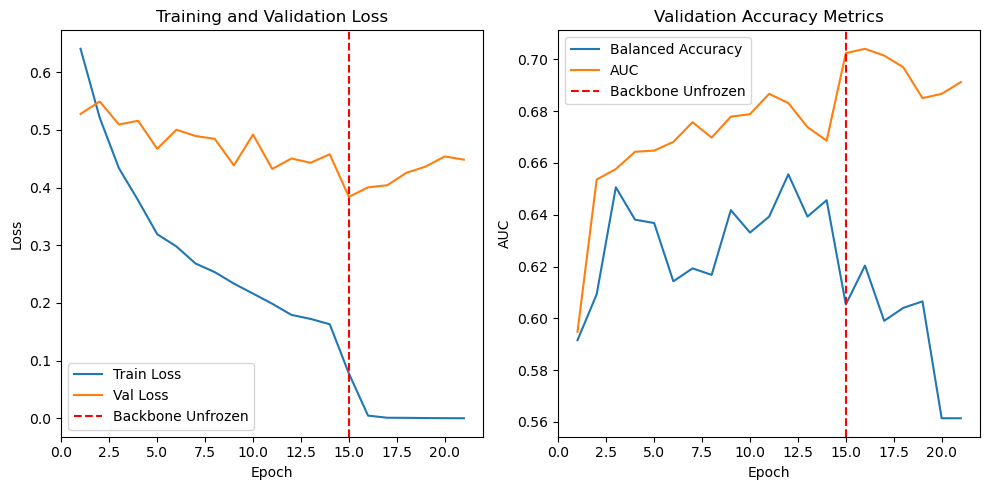

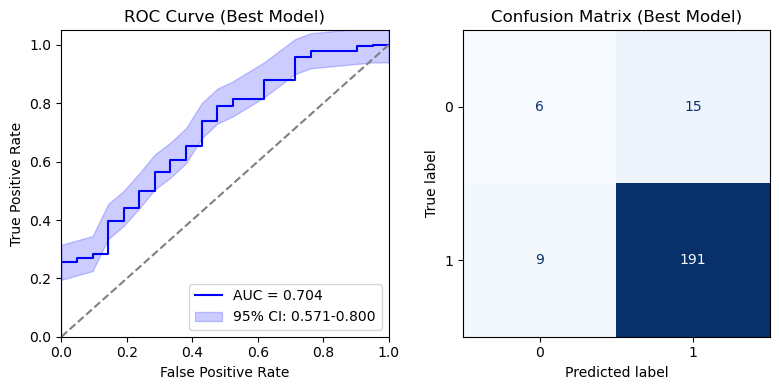

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Plot Loss and Accuracy (or AUC) ===
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Loss Plot ---
sns.lineplot(ax=axes[0], x=range(1, len(train_losses)+1), y=train_losses, label='Train Loss')
sns.lineplot(ax=axes[0], x=range(1, len(val_losses)+1), y=val_losses, label='Val Loss')
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
if isinstance(backbone_unfrozen_epoch, int):
    axes[0].axvline(backbone_unfrozen_epoch, color='red', linestyle='--', label='Backbone Unfrozen')
    axes[0].legend()

# --- Accuracy or AUC Plot ---
sns.lineplot(ax=axes[1], x=range(1, len(val_bal_accs)+1), y=val_bal_accs, label='Balanced Accuracy')
sns.lineplot(ax=axes[1], x=range(1, len(val_metric_vals)+1), y=val_metric_vals, label=metric_label)
axes[1].set_title("Validation Accuracy Metrics")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy" if metric_label != "AUC" else "AUC")
#axes[1].set_ylim(0.5, 1)
axes[1].legend()
if isinstance(backbone_unfrozen_epoch, int):
    axes[1].axvline(backbone_unfrozen_epoch, color='red', linestyle='--', label='Backbone Unfrozen')
    axes[1].legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Load best model and run inference ===
model.load_state_dict(torch.load("best_resnet.pt"))
model.eval()
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs[:, 1])  # Prob of positive class
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# === ROC + AUC ===
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# === Bootstrap AUC CI ===
bootstrapped_scores = []
rng = np.random.RandomState(42)
for _ in range(len(y_val)):
    indices = rng.randint(0, len(all_labels), len(all_labels))
    if len(np.unique(all_labels[indices])) < 2:
        continue
    score = roc_auc_score(all_labels[indices], all_probs[indices])
    bootstrapped_scores.append(score)

ci_lower = np.percentile(bootstrapped_scores, 2.5)
ci_upper = np.percentile(bootstrapped_scores, 97.5)
#print(f"AUC = {roc_auc:.4f} (95% CI: {ci_lower:.4f} – {ci_upper:.4f})")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# === Plot ROC + Confusion Matrix ===
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC Plot
axes[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='blue')
axes[0].fill_between(
    fpr,
    np.interp(fpr, fpr, tpr) - np.std(bootstrapped_scores),
    np.interp(fpr, fpr, tpr) + np.std(bootstrapped_scores),
    color='blue', alpha=0.2,
    label=f"95% CI: {ci_lower:.3f}-{ci_upper:.3f}"
)
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Best Model)")
axes[0].legend(loc="lower right")

# Confusion Matrix Plot
disp.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title("Confusion Matrix (Best Model)")
plt.tight_layout()
plt.show()

# Multiclass Predictor

In [31]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, classification_report, roc_auc_score
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# === Parameters ===
working_dir = "/data/lodhar2/milan"
os.chdir(working_dir)
TRAIN_PATH = "data/resnet_train.npz"
VAL_PATH = "data/resnet_val.npz"
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# === Reproducibility ===
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# === Load data ===
print("Loading data...")
train_data = np.load(TRAIN_PATH, allow_pickle=True)
val_data = np.load(VAL_PATH, allow_pickle=True)

X_train = torch.tensor(train_data["images"]).float()
X_val = torch.tensor(val_data["images"]).float()

# === Label encoding ===
unique_labels = np.unique(train_data["labels"])
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

y_train = torch.tensor([label_to_idx[label] for label in train_data["labels"]]).long()
y_val = torch.tensor([label_to_idx[label] for label in val_data["labels"]]).long()
num_classes = len(unique_labels)
print(f"Detected {num_classes} classes: {unique_labels}")

# === DataLoaders ===
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

# === Metrics ===
def top_k_accuracy(y_true, y_probs, k=2):
    top_k_preds = np.argsort(y_probs, axis=1)[:, -k:]
    correct = sum(label in top_k for label, top_k in zip(y_true, top_k_preds))
    return correct / len(y_true)

# === Model ===
print("Loading ResNet-50...")
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(DEVICE)

# === Freeze backbone ===
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# === Optimizer, Loss, Scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# === Training ===
best_metric = float('-inf')
patience_counter = 0
backbone_unfrozen_epoch = None

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch} - Train Loss: {avg_train_loss:.4f}")

    # --- Validate ---
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.append(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_probs = np.vstack(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    top2_acc = top_k_accuracy(all_labels, all_probs, k=2)
    print(f"Val Loss: {avg_val_loss:.4f} | Balanced Accuracy: {bal_acc:.4f} | Top-2 Accuracy: {top2_acc:.4f}")

    # === Save best ===
    if top2_acc > best_metric:
        best_metric = top2_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_resnet.pt")
        print("New best model saved.")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=[idx_to_label[i] for i in range(num_classes)], digits=4))
    else:
        patience_counter += 1
        print(f"Patience counter: {patience_counter}")

        # === Optional: Unfreeze backbone ===
        if patience_counter == (PATIENCE // 2 + 1) and backbone_unfrozen_epoch is None:
            print("Unfreezing backbone...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=1e-4)
            backbone_unfrozen_epoch = epoch + 1

        if patience_counter >= PATIENCE:
            print("Early stopping.")
            break

Using device: cuda
Loading data...
Detected 6 classes: ['Angiomyolipoma' 'Chromophobe' 'Clear_cell' 'Hybrid' 'Oncocytoma'
 'Papillary']
Loading ResNet-50...

Epoch 1 - Train Loss: 1.7658
Val Loss: 1.7694 | Balanced Accuracy: 0.2294 | Top-2 Accuracy: 0.3682
New best model saved.

Classification Report:
                precision    recall  f1-score   support

Angiomyolipoma     0.0000    0.0000    0.0000        16
   Chromophobe     0.1892    0.3333    0.2414        21
    Clear_cell     0.7143    0.0676    0.1235        74
        Hybrid     0.3333    0.2250    0.2687        40
    Oncocytoma     0.0769    0.0909    0.0833        22
     Papillary     0.2541    0.6596    0.3669        47

      accuracy                         0.2455       220
     macro avg     0.2613    0.2294    0.1806       220
  weighted avg     0.3809    0.2455    0.2001       220


Epoch 2 - Train Loss: 1.5948
Val Loss: 1.7767 | Balanced Accuracy: 0.1941 | Top-2 Accuracy: 0.3955
New best model saved.

Classificat

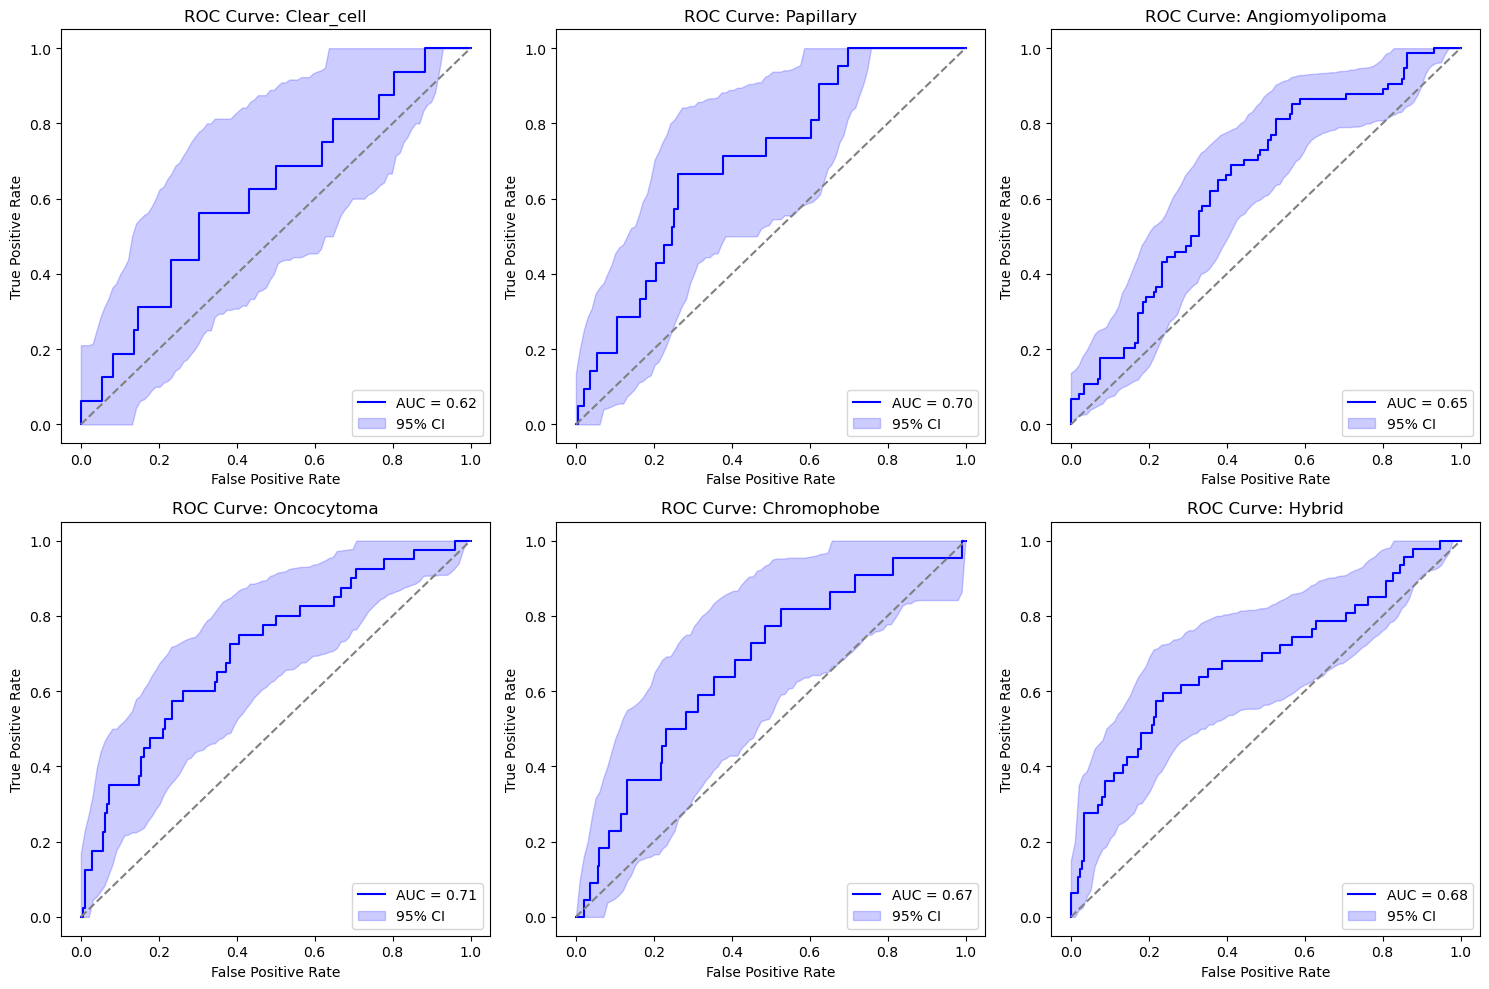

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# === Define class order ===
class_order = ['Clear_cell', 'Papillary', 'Angiomyolipoma', 'Oncocytoma', 'Chromophobe', 'Hybrid']
class_to_idx = {cls: idx for idx, cls in enumerate(class_order)}

# === Convert all_labels to integer indices if needed ===
if isinstance(all_labels[0], str):
    label_indices = np.array([class_to_idx[label] for label in all_labels])
else:
    label_indices = np.array(all_labels)

# === all_probs must be a 2D array: (n_samples, n_classes)
# If you used .append(probs) during training, make sure to call:
# all_probs = np.vstack(all_probs)

# === Plot setup ===
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

rng = np.random.RandomState(42)

for i, cls in enumerate(class_order):
    idx = class_to_idx[cls]

    # Binary ground truth for one-vs-all
    binary_labels = (label_indices == idx).astype(int)
    binary_probs = all_probs[:, idx]  # Prob for class `cls`

    # ROC and AUC
    fpr, tpr, _ = roc_curve(binary_labels, binary_probs)
    roc_auc = auc(fpr, tpr)

    # === Bootstrap CI ===
    fpr_linspace = np.linspace(0, 1, 100)
    tpr_bootstrap = []

    for _ in range(1000):
        indices = rng.randint(0, len(binary_labels), len(binary_labels))
        if len(np.unique(binary_labels[indices])) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(binary_labels[indices], binary_probs[indices])
        tpr_interp = np.interp(fpr_linspace, fpr_b, tpr_b)
        tpr_bootstrap.append(tpr_interp)

    tpr_bootstrap = np.array(tpr_bootstrap)
    tpr_lower = np.percentile(tpr_bootstrap, 2.5, axis=0)
    tpr_upper = np.percentile(tpr_bootstrap, 97.5, axis=0)

    # === Plot ===
    axs[i].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="blue")
    axs[i].fill_between(fpr_linspace, tpr_lower, tpr_upper, color='blue', alpha=0.2, label="95% CI")
    axs[i].plot([0, 1], [0, 1], linestyle='--', color='gray')

    axs[i].set_title(f"ROC Curve: {cls}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    axs[i].legend(loc="lower right")

plt.tight_layout()
plt.show()

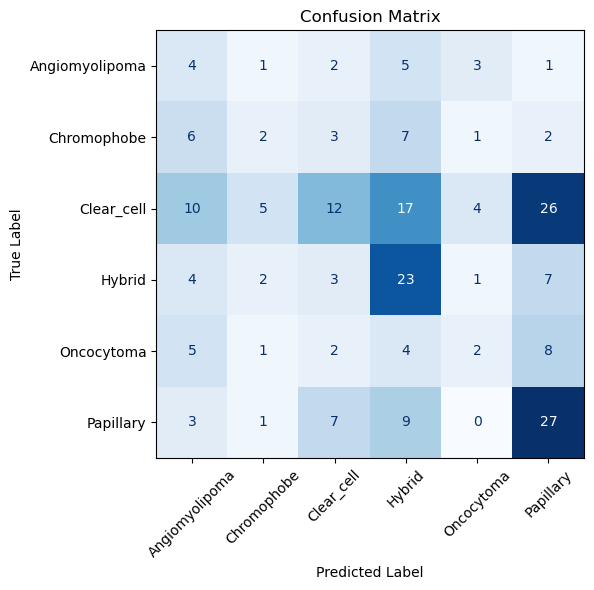

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === Inputs ===
# all_labels: true labels (numeric)
# all_preds: predicted labels (numeric)
# idx_to_label: mapping from integer index to string class name (from training)

# Convert numeric labels to class names (optional)
target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)

# === Display ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()